<a href="https://colab.research.google.com/github/Kufzuk2/Comp_math/blob/main/sem2_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def robertson_system(t, y):
    """
    Система уравнений Робертсона
    y = [y1, y2, y3]
    """
    dy1 = -0.04 * y[0] + 1e4 * y[1] * y[2]
    dy2 = 0.04 * y[0] - 1e4 * y[1] * y[2] - 3e7 * y[1]**2
    dy3 = 3e7 * y[1]**2
    return np.array([dy1, dy2, dy3])

In [11]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def robertson_system(t, y):
    dy1 = -0.04*y[0] + 1e4*y[1]*y[2]
    dy2 = 0.04*y[0] - 1e4*y[1]*y[2] - 3e7*y[1]**2
    dy3 = 3e7*y[1]**2
    return np.array([dy1, dy2, dy3])

In [12]:
def explicit_rk4(f, y0, t_span, h):
    t0, tf = t_span
    n = int((tf - t0)/h)
    t = np.linspace(t0, tf, n+1)
    y = np.zeros((n+1, len(y0)))
    y[0] = y0

    for i in range(n):
        k1 = f(t[i], y[i])
        k2 = f(t[i] + h/2, y[i] + h/2*k1)
        k3 = f(t[i] + h/2, y[i] + h/2*k2)
        k4 = f(t[i] + h, y[i] + h*k3)
        y[i+1] = y[i] + h/6*(k1 + 2*k2 + 2*k3 + k4)

    return t, y

In [13]:
def implicit_rk3(f, y0, t_span, h):
    t0, tf = t_span
    n = int((tf - t0)/h)
    t = np.linspace(t0, tf, n+1)
    y = np.zeros((n+1, len(y0)))
    y[0] = y0

    # Коэффициенты метода (Radau IIA 3 порядка)
    A = np.array([[5/12, -1/12], [3/4, 1/4]])
    b = np.array([3/4, 1/4])
    c = np.array([1/3, 1])

    for i in range(n):
        def equations(k):
            k1, k2 = k[0:3], k[3:6]
            eq1 = k1 - f(t[i] + c[0]*h, y[i] + h*(A[0,0]*k1 + A[0,1]*k2))
            eq2 = k2 - f(t[i] + c[1]*h, y[i] + h*(A[1,0]*k1 + A[1,1]*k2))
            return np.concatenate((eq1, eq2))

        k_sol = fsolve(equations, np.zeros(6))
        k1, k2 = k_sol[0:3], k_sol[3:6]
        y[i+1] = y[i] + h*(b[0]*k1 + b[1]*k2)

    return t, y

In [14]:
def bdf3(f, y0, t_span, h):
    t0, tf = t_span
    n = int((tf - t0)/h)
    t = np.linspace(t0, tf, n+1)
    y = np.zeros((n+1, len(y0)))

    # Разгонный участок (используем RK4)
    t_rk, y_rk = explicit_rk4(f, y0, (t0, t0 + 2*h), h)
    y[0:3] = y_rk

    for i in range(2, n):
        def equation(y_next):
            return y_next - (18/11*y[i] - 9/11*y[i-1] + 2/11*y[i-2] +
                           6/11*h*f(t[i+1], y_next))

        y[i+1] = fsolve(equation, y[i])

    return t, y

In [15]:
def rosenbrock3(f, y0, t_span, h):
    t0, tf = t_span
    n = int((tf - t0)/h)
    t = np.linspace(t0, tf, n+1)
    y = np.zeros((n+1, len(y0)))
    y[0] = y0

    gamma = 0.5 + np.sqrt(3)/6
    a21, a31, a32 = 2, 48/25, 6/25
    c2, c3 = 1, 0.6

    for i in range(n):
        # Якобиан (численное приближение)
        def jacobian(y):
            eps = 1e-8
            J = np.zeros((3, 3))
            f0 = f(t[i], y)
            for j in range(3):
                y_eps = y.copy()
                y_eps[j] += eps
                J[:,j] = (f(t[i], y_eps) - f0)/eps
            return J

        J = jacobian(y[i])
        I = np.eye(3)

        # Первая стадия
        LHS = I - h*gamma*J
        RHS = f(t[i], y[i])
        k1 = np.linalg.solve(LHS, RHS)

        # Вторая стадия
        y2 = y[i] + a21*k1
        LHS = I - h*gamma*J
        RHS = f(t[i] + c2*h, y2) - a21*h*J.dot(k1)
        k2 = np.linalg.solve(LHS, RHS)

        # Третья стадия
        y3 = y[i] + a31*k1 + a32*k2
        LHS = I - h*gamma*J
        RHS = f(t[i] + c3*h, y3) - h*J.dot(a31*k1 + a32*k2)
        k3 = np.linalg.solve(LHS, RHS)

        y[i+1] = y[i] + 1.5*k1 - 0.5*k2 + 1.5*k3

    return t, y

In [16]:
y0 = np.array([1.0, 0.0, 0.0])
t_span = (0, 40)
h = 1e-5  # Шаг для явного метода (подбирается экспериментально)
h_implicit = 1e-2  # Шаг для неявных методов

In [17]:
# Явный метод (только для малых времен)
t_rk4, y_rk4 = explicit_rk4(robertson_system, y0, (0, 1e-3), h)

# Неявные методы
t_irk3, y_irk3 = implicit_rk3(robertson_system, y0, t_span, h_implicit)
t_bdf3, y_bdf3 = bdf3(robertson_system, y0, t_span, h_implicit)
t_ros3, y_ros3 = rosenbrock3(robertson_system, y0, t_span, h_implicit)

<ipython-input-13-a4dc982172bf>:20: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  k_sol = fsolve(equations, np.zeros(6))
<ipython-input-11-e4376ee9c02f>:6: RuntimeWarning: overflow encountered in scalar multiply
  dy1 = -0.04*y[0] + 1e4*y[1]*y[2]
<ipython-input-11-e4376ee9c02f>:7: RuntimeWarning: overflow encountered in scalar multiply
  dy2 = 0.04*y[0] - 1e4*y[1]*y[2] - 3e7*y[1]**2
<ipython-input-11-e4376ee9c02f>:7: RuntimeWarning: overflow encountered in scalar power
  dy2 = 0.04*y[0] - 1e4*y[1]*y[2] - 3e7*y[1]**2
<ipython-input-11-e4376ee9c02f>:7: RuntimeWarning: invalid value encountered in scalar subtract
  dy2 = 0.04*y[0] - 1e4*y[1]*y[2] - 3e7*y[1]**2
<ipython-input-11-e4376ee9c02f>:8: RuntimeWarning: overflow encountered in scalar power
  dy3 = 3e7*y[1]**2
<ipython-input-14-6705a2b9d0e9>:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten 

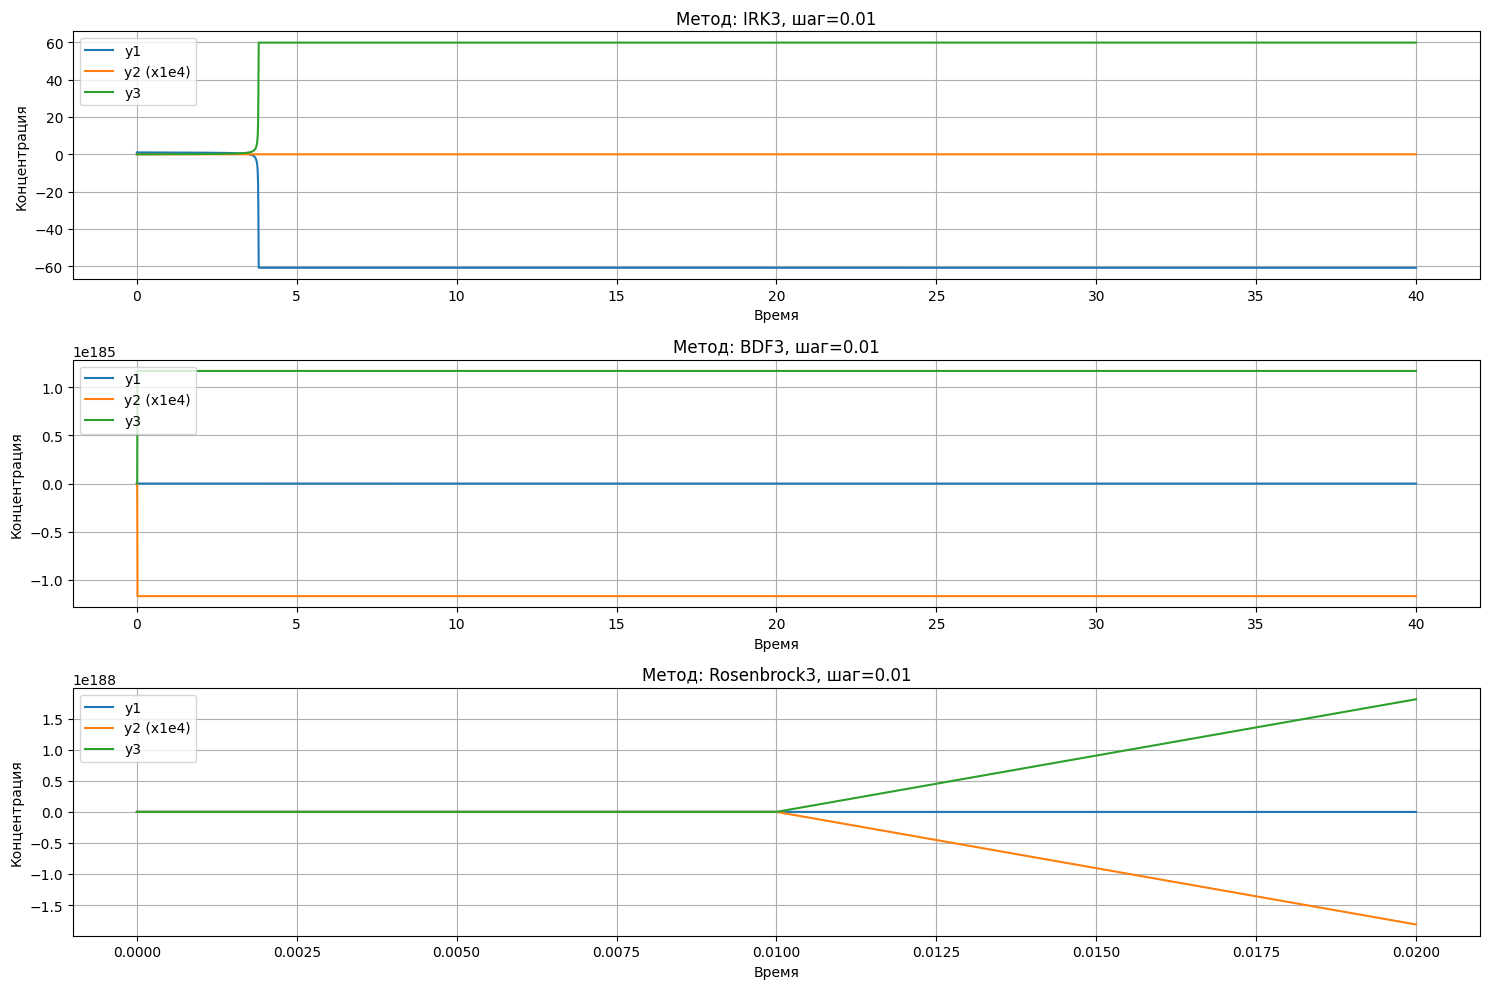

In [18]:
plt.figure(figsize=(15, 10))

# Графики для неявных методов
methods = [('IRK3', t_irk3, y_irk3),
           ('BDF3', t_bdf3, y_bdf3),
           ('Rosenbrock3', t_ros3, y_ros3)]

for i, (name, t, y) in enumerate(methods):
    plt.subplot(3, 1, i+1)
    plt.plot(t, y[:, 0], label='y1')
    plt.plot(t, y[:, 1], label='y2 (x1e4)')
    plt.plot(t, y[:, 2], label='y3')
    plt.title(f'Метод: {name}, шаг={h_implicit}')
    plt.xlabel('Время')
    plt.ylabel('Концентрация')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()